#Требования (эта версия или выше)

#Глобальные параметры

###число ядер для распараллеливания

In [2]:
n_cores = 15

###количество разбиений на обучающую/валидационную выборку, по которым усредняются результаты и находятся их стандартные отклонения

In [ ]:
n_seeds = 10

#Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from pandas import read_csv

import sys

import logging
reload(logging)
logging.basicConfig(format = u'[%(asctime)s]  %(message)s', level = logging.INFO)
logging.info('')

import sklearn, random, sys, os
from __future__ import division

sys.path.append('/home/ubuntu/xgboost/wrapper/')
import xgboost as xgb

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import *
from sklearn import linear_model, svm
from sklearn.metrics import mean_squared_error, log_loss
from copy import deepcopy
from sklearn import cross_validation
from sklearn.grid_search import *
from sklearn.externals import joblib

def figsize(x,y) :
    figure(figsize = (x,y))
    
from sklearn import preprocessing

from matplotlib.pyplot import *
%matplotlib inline

def sigm(x):
    return 1 / (1 + np.exp(-x))

def accuracy(y_true, y_pred):
    if type(y_pred) == list :
        y_pred = np.array(y_pred).T
    
    return np.mean([j == np.argmax(i) for j,i in zip(y_true, y_pred)])

accuracy_scorer = sklearn.metrics.make_scorer(accuracy, greater_is_better=True, needs_proba=True)

def concat(x):
    x = [element for element in x if element is not None]
    return np.concatenate(x, axis=1)

def multilogloss(y_true, y_pred, meanloss=True):
    try :
        y_pred.shape[1] != 9
    except :
        try :
            y_pred = np.array([p[:,1] for p in y_pred]).T
        except: 
            try :
                y_pred = np.array(y_pred).T
            except:
                pass
    y_pred /= np.sum(y_pred, axis=1)[:,np.newaxis]
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = []
    if y_true.shape[0] == np.sum(y_true.shape) :
        for i in range(y_pred.shape[1]):
            loss_i = - np.sum((y_true == i) * np.log(y_pred[:,i]))
            loss += [loss_i]
    else:
        for i in range(y_pred.shape[1]):
            loss_i = + np.sum((y_true[:,i] == 1) * np.log(y_pred[:,i]))
            loss += [loss_i]
            
    if meanloss :
        return np.sum(loss) / y_true.shape[0]
    else :
        return loss

[2015-06-21 11:13:28,735]  


#Загрузка данных

In [3]:
from sklearn.datasets import fetch_covtype
forest = fetch_covtype()

#Функции для построения метафич

In [1]:
#функция для работы с базовыми классификаторами из sklearn

def oof_sklearn(i, alg, Xtrain, Xtest, Ytrain, mask, test_averaging=True):
    
    ansmask = []
    ytrain_i = np.zeros((Xtrain.shape[0], len(np.unique(Ytrain))))
    
    for m1,m2 in mask:

        alg.fit(Xtrain[m1], Ytrain[m1])
        try:
            ytrain_i[m2] = alg.predict_proba(Xtrain[m2])
            ansmask += [alg.predict_proba(Xtest)]
        except:
            ytrain_i[m2] = alg.decision_function(Xtrain[m2])
            ansmask += [alg.decision_function(Xtest)]
    
    ansmask = sum(ansmask)/len(mask)
    
    if not test_averaging:
        alg.fit(Xtrain, Ytrain)
        try:
            ansmask = alg.predict_proba(Xtest)
        except:
            ansmask = alg.decision_function(Xtest)

    return ytrain_i, ansmask

In [4]:
#функция для работы с базовым классификатором из XGBoost
def oof_xgboost(i, alg, Xtrain, Xtest, Ytrain, mask, test_averaging):
    
    ansmask = []
    ytrain_i = np.zeros((Xtrain.shape[0], len(np.unique(Ytrain))))
    best_iters = []
    Gtest = xgb.DMatrix( Xtest )
    
    for m1,m2 in mask:
        Gtrain1 = xgb.DMatrix( Xtrain[m1], label = Ytrain[m1] )
        Gtrain2 = xgb.DMatrix( Xtrain[m2], label = Ytrain[m2] )
        
        evallist = [(Gtrain1,'train1'), (Gtrain2,'train2')]
        bst = xgb.train( plst, Gtrain1, num_round, evallist, early_stopping_rounds = 10 )
        best_iters += [bst.best_iteration]
        
        ytrain_i[m2] += bst.predict(Gtrain2)
        ansmask += [bst.predict(Gtest)]
    
    #Style of test metafeature
    if test_averaging :
        # Average metafeature using K classifiers for each K-1 group of folds
        return ytrain_i, sum(ansmask)/len(mask)
    else :
        # Train single model to get metafeature
        Gtrain = xgb.DMatrix( Xtrain, label = Ytrain )
        bst = xgb.train( plst, Gtrain, int(np.mean(best_iters))+10 )
        ansmask = bst.predict(Gtest)
        return ytrain_i, ansmask

In [9]:
#основная функция, контролирующая получение метафичи
def out_of_fold(folds, n_times, algorithm, Xtrain, Xtest, Ytrain, test_averaging=True):
    
    if algorithm == 'xgboost':
        oof_function = oof_xgboost
    else:
        oof_function = oof_sklearn
    
    if type(folds) == int :
        masks = [sklearn.cross_validation.StratifiedKFold(Ytrain, n_folds=folds, shuffle=True) for i in range(n_times)]
        def ftemp(i) : return oof_function(i, algorithm, Xtrain, Xtest, Ytrain, masks[i], test_averaging=test_averaging)
    else :
        def ftemp(i) : return oof_function(i, algorithm, Xtrain, Xtest, Ytrain, folds, test_averaging=test_averaging)
    
    ans = map(ftemp, range(n_times))
    return sum([i[0] for i in ans]) / n_times, sum([i[1] for i in ans]) / n_times

#Параметры для XGBoost

In [7]:
%%time
%%capture --no-stdout --no-display

param = {}
param['booster'] = 'gbtree'
param['objective'] = 'multi:softprob'
param['max_depth'] = 15
param['eta'] = .1
#param['colsample_bytree'] = .75
#param['subsample'] = .75
param['num_class'] = len(np.unique(forest.target))
param['silent'] = 1
param['nthread'] = 15
plst = list(param.items()) #+ [('eval_metric', 'merror')]
num_round = 10000

CPU times: user 10.2 ms, sys: 4.77 ms, total: 15 ms
Wall time: 14 ms


#Multiclass logloss ошибка базового классификатора, обученного на всей обучающей выборке

In [211]:
%%time
%%capture --no-stdout --no-display

metafeature_clf_score = 0
best_iters = []

for i in range(n_seeds):
    train, test, target, target_test = train_test_split(forest.data, forest.target-forest.target.min(), \
                                                    train_size=15000, test_size=15000, random_state=i)
    Gtrain = xgb.DMatrix( train, label = target )
    Gtest = xgb.DMatrix( test, label = target_test )

    evallist = [(Gtrain,'train'), (Gtest,'test')]
    
    bst = xgb.train( plst, Gtrain, num_round, evallist, early_stopping_rounds = 10 )
    best_iters += [bst.best_iteration]

    level_1_clf_score += multilogloss(target_test, bst.predict(Gtest))

level_1_clf_score = np.mean(level_1_clf_score)
best_iters = np.mean(best_iters)
print best_iters
print level_1_clf_score

121.0
0.402084436849
CPU times: user 1h 38min 28s, sys: 1.98 s, total: 1h 38min 30s
Wall time: 6min 34s


#Создание метапризнаков

###(K-1)*N

In [3]:
complexity = 100

###для скольки блоков (K-fold) создать метапризнаки

In [ ]:
folds = [2,3,5,7,10]

###создание

In [ ]:
%%time
%%capture --no-stdout --no-display

MF_seeds = []
for i in range(n_seeds):
    print i
    train, test, target, target_test = train_test_split(forest.data, forest.target-forest.target.min(), \
                                                    train_size=15000, test_size=15000, random_state=i)
    
    MF = []
    
    #oof(K, test_averaging=True)
    MF += [[]]
    for n_folds in folds:
        n_times = int(complexity/(n_folds-1))
        print n_folds, n_times
        mask = sklearn.cross_validation.StratifiedKFold(target, n_folds=n_folds, shuffle=True, random_state=0)
        MF[-1] += [out_of_fold(mask, n_times, 'xgboost', train, test, target, test_averaging=True)]

    #oof(K, test_averaging=False)
    MF += [[]]
    for n_folds in folds:
        n_times = int(complexity/(n_folds-1))
        print n_folds, n_times
        mask = sklearn.cross_validation.StratifiedKFold(target, n_folds=n_folds, shuffle=True, random_state=0)
        MF[-1] += [out_of_fold(mask, n_times, 'xgboost', train, test, target, test_averaging=False)]
    
    #oof(K, test_averaging=True)*N
    MF += [[]]
    for n_folds in folds:
        n_times = int(complexity/(n_folds-1))
        print n_folds, n_times
        MF[-1] += [out_of_fold(n_folds, n_times, 'xgboost', train, test, target, test_averaging=True)]

    #oof(K, test_averaging=False)*N
    MF += [[]]
    for n_folds in folds:
        n_times = int(complexity/(n_folds-1))
        print n_folds, n_times
        MF[-1] += [out_of_fold(n_folds, n_times, 'xgboost', train, test, target, test_averaging=False)]
        
    MF_seeds += [MF]

#Качество метаклассификатора на всей обучающей выборке без метапризнаков

In [ ]:
%%time
def what_accuracy_advanced(pair_of_MF, train=train, test=test, target=target, target_test=target_test, N=10):
    
    advanced_clf = ExtraTreesClassifier(n_estimators=1000, n_jobs=n_cores)

    YtrainMF, YtestMF = pair_of_MF
    score = []
    prediction = 0
    
    for i in range(N):
        advanced_clf.set_params(random_state=i)
        advanced_clf.fit(concat([train, YtrainMF]), target)
        prediction += advanced_clf.predict_proba(concat([test, YtestMF]))
    
    return accuracy(target_test, prediction/N)

score = []
for seed in range(n_seeds):
    train, test, target, target_test = train_test_split(forest.data, forest.target-forest.target.min(), \
                                                train_size=15000, test_size=15000, random_state=seed)
    score += [what_accuracy_advanced([None, None], train=train, test=test, target=target, target_test=target_test)]

advanced_clf_score = np.mean(score)
print advanced_clf_score

#Обучение метаклассификатора на полученных метапризнаках

In [ ]:
%%time
def different_seeds_to_mean_std(result_list):
    
    y_list = [[[] for j in range(np.array(result_list).shape[2])] for i in range(np.array(result_list).shape[1])]
    y_train = [[[] for j in range(np.array(result_list).shape[2])] for i in range(np.array(result_list).shape[1])]
    y_test = [[[] for j in range(np.array(result_list).shape[2])] for i in range(np.array(result_list).shape[1])]
    
    for seed, result in zip(range(len(result_list)), result_list):
        train, test, target, target_test = train_test_split(forest.data, forest.target-forest.target.min(), \
                                                    train_size=15000, test_size=15000, random_state=seed)
    
        for ip, exp in enumerate(result):
            
            for ir,iexp in enumerate(exp):
                trainP, testP = iexp

                y_list[ip][ir] += [what_accuracy_advanced([trainP, testP], train=train, test=test, target=target, \
                                                          target_test=target_test)]
                y_train[ip][ir] += [multilogloss(target, trainP)]
                y_test[ip][ir] += [multilogloss(target_test, testP)]
    
    return [[np.mean(i) for i in y] for y in y_list], [[np.std(i) for i in y] for y in y_list], \
            [[np.mean(i) for i in y] for y in y_train], [[np.std(i) for i in y] for y in y_train],\
            [[np.mean(i) for i in y] for y in y_test], [[np.std(i) for i in y] for y in y_test]

scores = different_seeds_to_mean_std(MF_seeds[:])

#Графики

In [7]:
MF_legend = ['oof(K), test_averaging=True', 'oof(K), test_averaging=False', \
             'oof(K)*N, test_averaging=True', 'oof(K)*N, test_averaging=False',  'metaclassifier on [X]']

###качество метаклассификатора для полученных метапризнаков

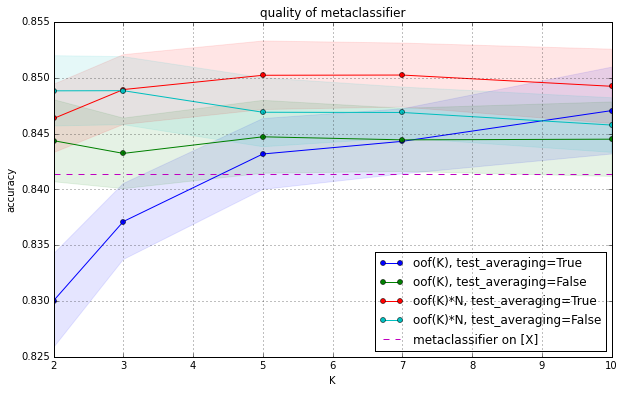

In [19]:
figsize(10,6)
colors = ['b', 'g', 'r', 'c', 'm']

for color,y_mean,y_std in zip(colors,scores[0], scores[1]):
    fill_between(folds, np.array(y_mean)-np.array(y_std), np.array(y_mean)+np.array(y_std), color=color, alpha=.1)  
    plot(folds, y_mean, marker='o', markersize=5)
    
plot([folds[0], folds[-1]], [advanced_clf_score] * 2, '--')

legend(MF_legend, 'lower right')
title('quality of metaclassifier')
ylabel('accuracy')
xlabel('K')
grid()

###качество метаклассификатора для полученных метапризнаков и непосредственное качество метапризнаков на обучающей и валидационной выборках

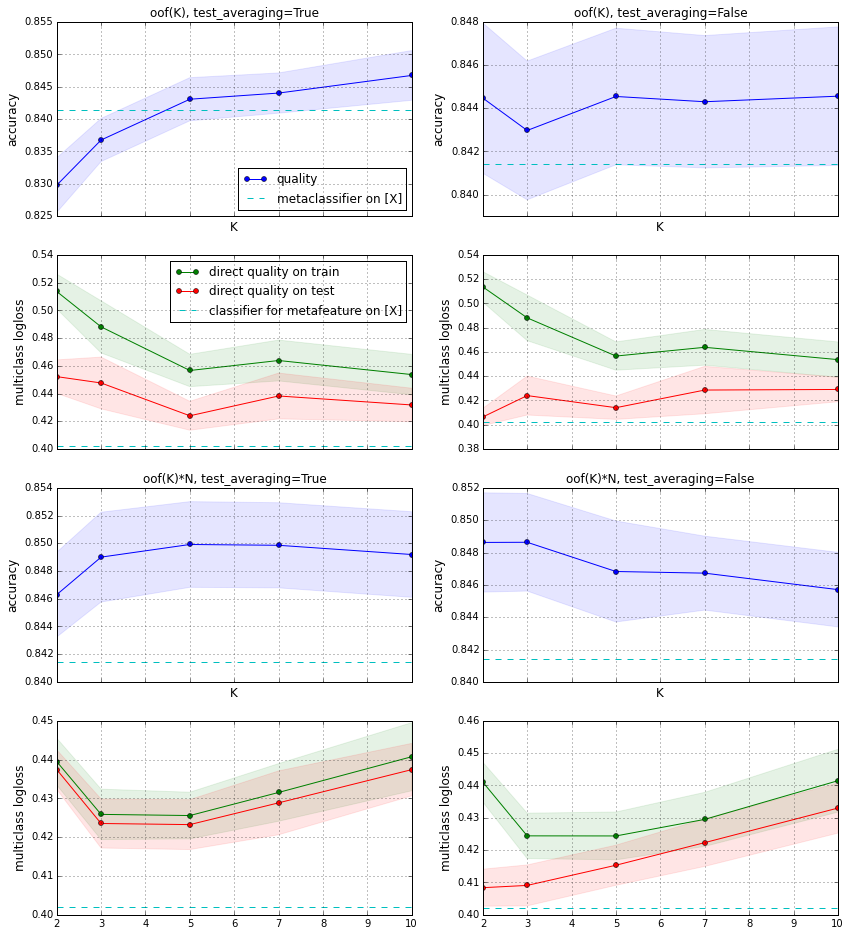

In [27]:
f, axarr = subplots(4, 2, sharex=True, sharey=False, figsize=(14,16))
colors = ['b', 'g', 'r', 'c', 'm']

for i,x,xstd,y,ystd,z,zstd,pair in zip(range(len(folds)),scores[0],scores[1],scores[2],scores[3],scores[4],scores[5],\
                                       [[0,0],[0,1],[1,0],[1,1]])[:]:
    ax = axarr[pair[0]*2, pair[1]]
    ay = axarr[pair[0]*2+1, pair[1]]
    ax.plot(folds, x, marker='o', markersize=5)
    ay.plot(folds, y, marker='o', markersize=5, c='g')
    ay.plot(folds, z, marker='o', markersize=5, c='r')
    
    ax.fill_between(folds, np.array(x)-np.array(xstd), np.array(x)+np.array(xstd), color=colors[0], alpha=.1)  
    ay.fill_between(folds, np.array(y)-np.array(ystd), np.array(y)+np.array(ystd), color=colors[1], alpha=.1)  
    ay.fill_between(folds, np.array(z)-np.array(zstd), np.array(z)+np.array(zstd), color=colors[2], alpha=.1)  
    
    ax.set_title(MF_legend[pair[0]*2 + pair[1]])
    ax.grid()
    ax.set_xlabel('K', fontsize=12)
    ax.set_ylabel('accuracy', fontsize=12)
    ax.plot([folds[0], folds[-1]], [advanced_clf_score] * 2, '--', c='c')
    
    ay.grid()
    #ay.set_xlabel('K')
    ay.set_ylabel('multiclass logloss', fontsize=12)
    ay.plot([folds[0], folds[-1]], [level_1_clf_score] * 2, '--', c='c')
            
axarr[0,0].legend(['quality', 'metaclassifier on [X]'], 'lower right')
axarr[1,0].legend(['direct quality on train', 'direct quality on test', 'classifier for metafeature on [X]'], 'upper right')

###Зависимость качества метаклассификатора от непосредственного качества метафичи

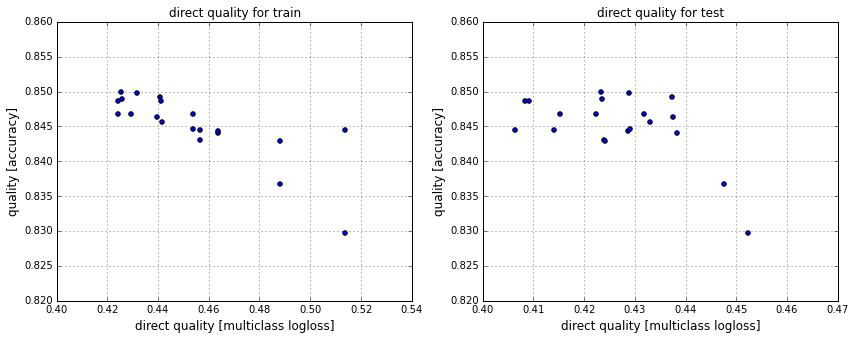

In [28]:
f, ax = subplots(1, 2, figsize=(14,5))
ay = ax[1]
ax = ax[0]

for i in range(4):
    ax.scatter(scores2[2][i], scores[0][i])
    ax.set_ylabel('quality [accuracy]', size=12)
    ax.set_xlabel('direct quality [multiclass logloss]', size=12)
    ax.grid(True)
    ax.set_title('direct quality for train')
    
    ay.scatter(scores2[4][i], scores[0][i])
    ay.set_ylabel('quality [accuracy]', size=12)
    ay.set_xlabel('direct quality [multiclass logloss]', size=12)
    ay.grid(True)
    ay.set_title('direct quality for test')

###Зависимость качества метаклассификатора от разности между непосредственным качеством метапризнаков на обучающей и валидационной выборках

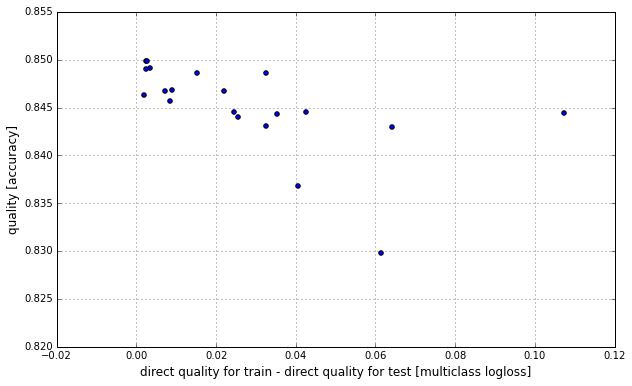

In [29]:
f, ax = subplots(1, 1, figsize=(10,6))

for i in range(4):
    ax.scatter(np.array(scores2[2][i])-np.array(scores2[4][i]), scores[0][i])
    ax.set_ylabel('quality [accuracy]', size=12)
    ax.set_xlabel('direct quality for train - direct quality for test [multiclass logloss]', size=12)
    ax.grid(True)